In [34]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.common.utils.text import build_vocab
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchlake.sequence_data.models.gru import GRUDiscriminator
from torchlake.sequence_data.models.base import RNNGenerator
from torchlake.sequence_data.models.seq2seq import Seq2Seq, GlobalAttention, LocalAttention, BahdanauAttention
from torchtext.data.utils import get_tokenizer
from torchlake.sequence_data.controller.trainer_rnn_generator import RNNGeneratorTrainer
from torchlake.common.controller.recorder import TrainRecorder
from torchtext.datasets import Multi30k
from tqdm import tqdm

To utilize this notebook, you have to install `spacy` and download `de_core_news_sm` and `en_core_web_sm` first

# setting

In [35]:
artifacts_path = Path("../../artifacts/seq2seq")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data/multi30k")

In [36]:
# no attention, 128
# global attention, 64
BATCH_SIZE = 128
CONTEXT = NlpContext()

In [37]:
DEVICE = torch.device(CONTEXT.device)

# data

In [38]:
SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'

In [39]:
tokenizers = {
    SRC_LANGUAGE: get_tokenizer('spacy', language=SRC_LANGUAGE), # de_core_news_sm
    TRG_LANGUAGE: get_tokenizer('spacy', language=TRG_LANGUAGE)  # en_web_core_sm
}

In [40]:
train_iter, val_iter, test_iter = Multi30k(
    data_path.as_posix(),
    language_pair=(SRC_LANGUAGE, TRG_LANGUAGE),
)

In [41]:
for src, trg in train_iter:
    print(src, trg)
    break

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche. Two young, White males are outside near many bushes.


In [42]:
# from torchtext.vocab.vectors import Vectors
# vector = Vectors("../../artifacts/glove/glove.6B.300d.txt")

In [43]:
# vocab = build_vocab(
#     map(lambda x: [x], vector.stoi.keys()),
#     context=NlpContext(min_frequency=0, min_seq_len=1),
# )

In [44]:
vocabs = {
    SRC_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[0]), train_iter), CONTEXT),
    # SRC_LANGUAGE: vocab,
    TRG_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[1]), train_iter), CONTEXT),
}

In [45]:
vocab_sizes = {
    SRC_LANGUAGE: len(vocabs[SRC_LANGUAGE]),
    TRG_LANGUAGE: len(vocabs[TRG_LANGUAGE]),
}

In [46]:
src_transform = T.Sequential(
    T.VocabTransform(vocabs[SRC_LANGUAGE]),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

trg_transform = T.Sequential(
    T.VocabTransform(vocabs[TRG_LANGUAGE]),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [47]:
def datapipe_factory(datapipe):
    return (
        datapipe.map(lambda pair: (pair[0].rstrip("\n"), pair[1].rstrip("\n")))
        # 1409.3215 p.2: reverse source sentence
        .map(lambda pair: (pair[0][::-1], pair[1]))
        .map(
            lambda pair: (
                tokenizers[SRC_LANGUAGE](pair[0]),
                tokenizers[TRG_LANGUAGE](pair[1]),
            )
        )
    )

In [48]:
train_datapipe, val_datapipe = datapipe_factory(train_iter), datapipe_factory(val_iter)

In [49]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_transform(src_sample))
        tgt_batch.append(trg_transform(trg_sample))

    return torch.stack(src_batch), torch.stack(tgt_batch)

In [50]:
NUM_WORKERS = get_num_workers()

In [51]:
train_loader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    val_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

In [52]:
for src, trg in train_loader:
    print(src.shape, trg.shape)
    break

torch.Size([64, 256]) torch.Size([64, 256])


# Model

In [53]:
NUM_LAYERS = 2
EMBED_DIM = 300
HIDDEN_DIM = 256
BIDIRECTIONAL = True

In [54]:
encoder = LSTMDiscriminator(
    vocab_sizes[SRC_LANGUAGE],
    EMBED_DIM,
    HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    drop_fc=True,
    context=CONTEXT,
)

In [55]:
# encoder.foot.weight.data.copy_(torch.cat([torch.rand(4, EMBED_DIM), vector.vectors],0 ))
# encoder.foot.weight.requires_grad_(False)

In [56]:
CONTEXT_SIZE = 2

attention = None

# attention = BahdanauAttention(
#     HIDDEN_DIM,
#     HIDDEN_DIM,
#     encoder_bidirectional=BIDIRECTIONAL,
# )

# attention = GlobalAttention(
#     HIDDEN_DIM,
#     HIDDEN_DIM,
#     encoder_bidirectional=BIDIRECTIONAL,
# )

# attention = LocalAttention(
#     HIDDEN_DIM,
#     HIDDEN_DIM,
#     encoder_bidirectional=BIDIRECTIONAL,
#     context_size=CONTEXT_SIZE,
# )

In [57]:
decoder = RNNGenerator(
    LSTMDiscriminator(
        vocab_sizes[TRG_LANGUAGE],
        EMBED_DIM,
        HIDDEN_DIM,
        output_size=vocab_sizes[TRG_LANGUAGE],
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        context=CONTEXT,
    ),
    attention=attention,
)

In [58]:
model = Seq2Seq(encoder, decoder, context=CONTEXT).to(DEVICE)

In [59]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─LSTMDiscriminator: 1-1                 --
│    └─Embedding: 2-1                    1,089,000
│    └─LSTM: 2-2                         2,719,744
│    └─LayerNorm: 2-3                    1,024
│    └─Identity: 2-4                     --
├─RNNGenerator: 1-2                      --
│    └─LocalAttention: 2-5               --
│    │    └─Linear: 3-1                  131,328
│    │    └─Linear: 3-2                  196,864
│    │    └─Linear: 3-3                  257
│    │    └─Linear: 3-4                  65,792
│    └─LSTMDiscriminator: 2-6            --
│    │    └─Embedding: 3-5               1,009,500
│    │    └─LSTM: 3-6                    2,719,744
│    │    └─LayerNorm: 3-7               1,024
│    │    └─Linear: 3-8                  1,726,245
Total params: 9,660,522
Trainable params: 9,660,522
Non-trainable params: 0

# Training

In [60]:
EPOCH = 10

In [61]:
trainer = RNNGeneratorTrainer(EPOCH, DEVICE, feature_last=True)
trainer.set_curriculum_strategy("inverse_sigmoid", k=10)

In [62]:
criterion = nn.CrossEntropyLoss(
    ignore_index=CONTEXT.padding_idx,
    reduction="sum",
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [63]:
recorder = TrainRecorder(total_epoch=EPOCH)
recorder.calc_dataset_size(map(lambda x: x[0], train_loader))

0it [00:00, ?it/s]

452it [00:10, 45.51it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\_jit_internal.py:1355: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(
454it [00:10, 43.03it/s]


29001

In [64]:
# to continue
# recorder.total_epoch = EPOCH

In [65]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [67]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    scaler=scaler,
    recorder=recorder,
)

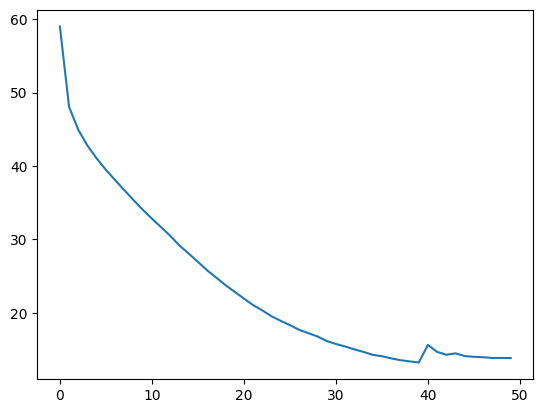

In [39]:
# plain, 4, bi
plt.plot(training_loss)

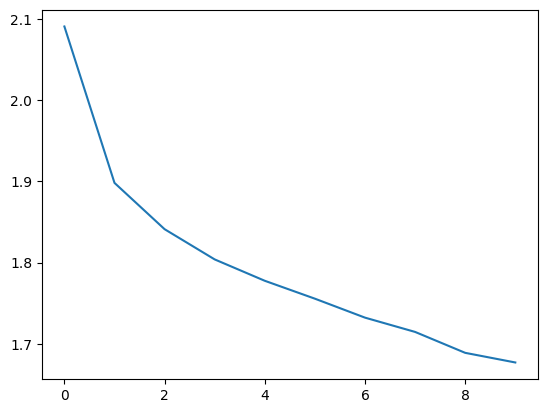

In [ ]:
# local, 2, bi
plt.plot(training_loss)

# Evaluate

In [ ]:
from torchmetrics.text import Perplexity

In [ ]:
metric = Perplexity(ignore_index=CONTEXT.padding_idx)

In [ ]:
model.eval()
running_loss = 0.0
data_count = 0
with torch.no_grad():
    for source_sentence, target_sentence in tqdm(test_loader):
        # data_count += len(source_sentence)
        text = source_sentence.to(DEVICE)
        label = target_sentence.to(DEVICE)
        # label = label[1:].view(-1)

        output = model.predict(text, topk=2)
        # output = torch.flatten(output[:, 1:], end_dim=-2)

        # loss = criterion(output.transpose(-1, -2), label)
        # running_loss += loss.item()
        metric.update(output.detach().cpu(), label.detach().cpu())

    # mean_loss = running_loss / data_count

# print(f"loss: {mean_loss}")
# print(f"perplexity: {math.exp(mean_loss)}")

0it [00:00, ?it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
7it [00:09,  1.36s/it]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\_jit_internal.py:1355: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(
8it [00:11,  1.38s/it]


In [ ]:
metric.compute()

tensor(146.6560)

In [30]:
from torchmetrics.text import BLEUScore

In [31]:
metric = BLEUScore()

In [ ]:
model.eval()
running_loss = 0.0
with torch.no_grad():
    for source_sentence, target_sentence in tqdm(test_loader):
        text = source_sentence.to(DEVICE)
        label = target_sentence.to(DEVICE)

        output = model.predict(text, topk=3)
        
        preds = []
        for o in output.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(o)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            preds.append(" ".join(translated[start_idx+1 : end_idx]))
            
        labels = []
        for l in label.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(l)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            labels.append(" ".join(translated[start_idx+1 : end_idx]))
        
        for pred, label in zip(preds, labels):
            metric.update(pred, [label])

In [ ]:
metric.compute()

tensor(0.)

# Translate

In [33]:
CLIP = 5

model.eval()
with torch.no_grad():
    for i, (source_sentence, target_sentence) in enumerate(val_iter):
        ori_source, ori_target = source_sentence.rstrip('\n'), target_sentence.rstrip('\n')
        source_sentence = tokenizers[SRC_LANGUAGE](source_sentence)
        source_sentence = src_transform(source_sentence)
        source_sentence = source_sentence.unsqueeze(0)
        source_sentence = source_sentence.to(DEVICE)
        
        target_sentence = tokenizers[TRG_LANGUAGE](target_sentence)
        target_sentence = trg_transform(target_sentence)
        target_sentence = target_sentence.unsqueeze(0)
        target_sentence = target_sentence.to(DEVICE)
        
        output = model.predict(source_sentence, topk=1)[0]
        
        # if EOS_IDX in outputs:
        translated = vocabs[TRG_LANGUAGE].lookup_tokens(output.tolist())
        start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
        # start_idx, end_idx =0, len(ori_target.split())
        print(f'第{i+1}句')
        print('source:', ori_source)
        print('target:', ori_target)
        print('output:', *translated[start_idx+1:end_idx], sep=' ')
        
        if i+1==CLIP: break

第1句
source: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
target: A group of men are loading cotton onto a truck
output: <unk> <unk> <unk> <unk> .
第2句
source: Ein Mann schläft in einem grünen Raum auf einem Sofa.
target: A man sleeping in a green room on a couch.
output:
第3句
source: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
target: A boy wearing headphones sits on a woman's shoulders.
output:
第4句
source: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
target: Two men setting up a blue ice fishing hut on an iced over lake
output: <unk> <unk> <unk> <unk> .
第5句
source: Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.
target: A balding man wearing a red life jacket is sitting in a small boat.
output: <unk> <unk> <unk> <unk> .


# visualization

In [38]:
source_embedding = model.foot.foot

In [39]:
from sklearn.decomposition import PCA

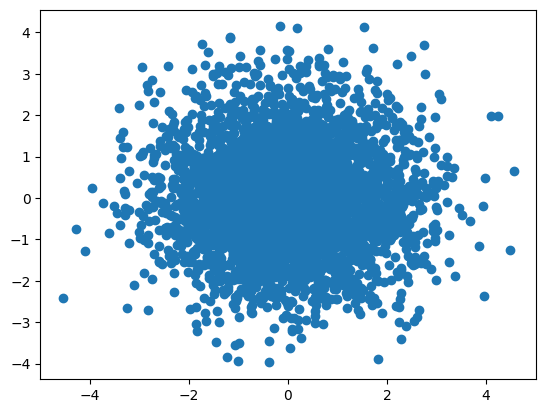

In [40]:
m = PCA(2)

plt.scatter(
    *m.fit_transform(source_embedding.weight.data.detach().cpu().numpy()).T,
)

In [41]:
target_embedding = model.head.head.foot

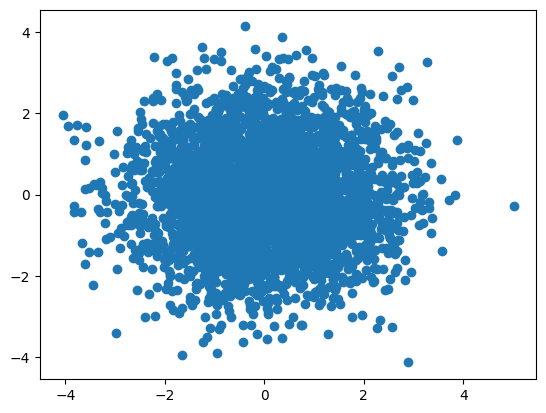

In [42]:
m = PCA(2)

plt.scatter(
    *m.fit_transform(source_embedding.weight.data.detach().cpu().numpy()).T,
)

# Save

In [28]:
from torchlake.common.controller.weight_manager import WeightManager

In [29]:
manager = WeightManager(artifacts_path.joinpath("seq2seq.{attention}.{bidirectional}.2.pth").as_posix())

In [30]:
attention_name = "plain"
if model.head.neck is not None:
    if isinstance(model.head.neck, GlobalAttention):
        attention_name = "global"
    elif isinstance(model.head.neck, LocalAttention):
        attention_name = "local"
    elif isinstance(model.head.neck, BahdanauAttention):
        attention_name = "bahdanau"


model_path = manager.get_filename(
    attention=attention_name,
    bidirectional="bi" if model.head.head.factor == 2 else "uni",
)
model_path

WindowsPath('../../artifacts/seq2seq/seq2seq.global.bi.2.pth')

In [38]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\seq2seq\seq2seq.global.bi.2.pth, model size is 36.61MiB


In [31]:
manager.load_weight(model_path, model)

# debug

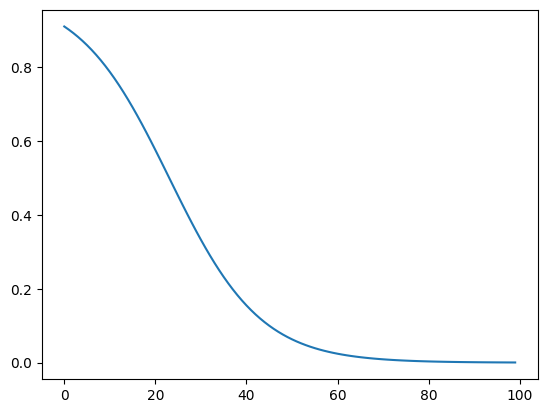

In [44]:
trainer = RNNGeneratorTrainer(EPOCH, DEVICE, feature_last=True)
trainer.set_curriculum_strategy("inverse_sigmoid", k=10)

ratios = []
for t in range(100):
    trainer.recorder.current_epoch = t
    ratios.append(trainer.teacher_forcing_raio)

plt.plot(ratios)